## **ICR - Identifying Age-Related Conditions Dataset** 

Baseline model: The person has none of the three conditions

Questions I have for the group: 

1. What should we do with the features that have lots of nulls? ('BQ' and 'EL'): imputing
2. How do we choose how many folds? Akabane et al.  mentions 5, Mythili et al. mentions 10, Kaggle notebook mentions 5: "golden standard is 10" (async)
3. Encode non-numeric data (EJ, Beta, Gamma, Epsilon)
4. Epsilon is a date: do we want to leave only the year?



Ask Cornelia:
- Does it make sense to do class weighting and k-fold cross-validation? (ChatGPT says yes)

In [ ]:
# Akabane et al. test/train split
akabane_train = (6564/8792)*100
akabane_test = (2228/8792)*100

print(f"Akabane et al train: {akabane_train:.0f}%, test: {akabane_test:.0f}%")
print("Alageel et al train: 80%, test: 20%")

#### ``Objectives``

#### ``Motivation``

#### ``Data``

### Step 1: Import libraries

In [ ]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sklearn.metrics as metrics


from sklearn.model_selection import KFold
from mlxtend.plotting import heatmap
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error


#improve figure resolution
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'


pd.set_option('display.max_columns', None) #show all columns
pd.set_option('display.max_rows', None) #show all columns



### Step 2: Define functions

In [ ]:
#auprc for metrics
def auprc(y_true, y_pred):
    precision, recall, _ = metrics.precision_recall_curve(y_true, y_pred)
    return metrics.auc(recall, precision)

### Step 3: Read data

In [ ]:
#set working directory
os.chdir('/Users/ecompu/Library/CloudStorage/OneDrive-Personal/Berkeley/W207_Machine_Learning/mids-207-final-project-summer23-Burzon-Brown-Caldera-Gomez/icr-identify-age-related-conditions/')

dataset_df = pd.read_csv('train.csv')
print("Full dataset shape is {}".format(dataset_df.shape)) 

In [ ]:
# data
dataset_df.head()

In [ ]:
# metadata
greeks_df = pd.read_csv('greeks.csv')
greeks_df.head()


### Step 4: Preprocess data

In [ ]:
# merge greeks and dataset
all_vars = dataset_df.merge(greeks_df, left_on='Id', right_on='Id')
all_vars.head()

In [ ]:
# check column names. Drop Alpha and Id because its also the class , and Id irrelevant 
all_vars = all_vars.drop(['Alpha','Id'], axis=1)
all_vars.columns

In [ ]:
# Check datatypes for each column
all_vars.dtypes

In [ ]:
#Change Unknown to Nan in order to format dates
all_vars['Epsilon'] = all_vars['Epsilon'].replace('Unknown', np.nan)  # Replace 'Unknown' with NaN

#split the date into DD/MM/YYYY
all_vars['Epsilon'] = pd.to_datetime(all_vars['Epsilon'])  # Convert the column to datetime format
all_vars['Day'] = all_vars['Epsilon'].dt.day.fillna(-1).astype(int)
all_vars['Month'] = all_vars['Epsilon'].dt.month.fillna(-1).astype(int)
all_vars['Year'] = all_vars['Epsilon'].dt.year.fillna(-1).astype(int)


all_vars['Day']
all_vars['Month']
all_vars['Year']

In [ ]:
all_vars.dtypes

In [ ]:
# dummies for categorical variables alpha, beta, gamma, ej
columns_to_dummy = ['Beta', 'Gamma', 'Delta','EJ']


# beta
beta_dummy = pd.get_dummies(
    all_vars['Beta'], prefix='Beta', dtype=int
)

# gamma
gamma_dummy = pd.get_dummies(
    all_vars['Gamma'], prefix='Gamma', dtype=int
)


# delta
delta_dummy = pd.get_dummies(
    all_vars['Delta'],prefix='Delta', dtype=int
)

# ej
ej_dummy = pd.get_dummies(
    all_vars['EJ'],prefix='EJ', dtype=int
)


# add to initial df
with_dummies_df = pd.concat(
    [all_vars,beta_dummy,gamma_dummy,ej_dummy],
    axis=1
)

with_dummies_df.dtypes

In [ ]:
#drop Beta, Gamma, Delta, Epsilon
all_vars = with_dummies_df.drop(['Beta','Gamma','Delta','Epsilon','EJ'], axis=1)
all_vars.columns


``split data into training and test``

In [ ]:
# define outcome #
##################
y = all_vars['Class'].values
y

# define features #
###################
columns = [i for i in all_vars.columns if i not in ['Class']] 

X = all_vars[columns].values


# split #
#########
split = (0.8,0.2) #80% training and 20% test
shuffle = np.random.permutation(np.arange(y.shape[0])) 
X, y = X[shuffle], y[shuffle]

splits = np.multiply(len(y), split).astype(int) 
X_train, X_test = np.split(X, [splits[0]])
y_train, y_test = np.split(y, [splits[0]])


# df for y_train and X_train #
##############################
# easier for EDA later on
df_train = pd.concat(
    [pd.DataFrame(y_train), pd.DataFrame(X_train)],
    axis=1
)

# # rename columns
df_train.columns=['Class', 'AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN', 'BP',
       'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS', 'CU',
       'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY', 'EB',
       'EE', 'EG', 'EH', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI', 'FL', 'FR',
       'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL',  'Day', 'Month',
       'Year', 'Beta_A', 'Beta_B', 'Beta_C', 'Gamma_A', 'Gamma_B', 'Gamma_E',
       'Gamma_F', 'Gamma_G', 'Gamma_H', 'Gamma_M', 'Gamma_N', 'EJ_A', 'EJ_B']

In [ ]:
print('Shape X_train: ', X_train.shape, '\nShape X_test: ', X_test.shape,
      '\nShape y_train: ', y_train.shape, '\nShape y_test:', y_test.shape)

### Step 5: EDA


1. Columns: 1 Class column (0/1) and 71 features (with one-hot encoding for categorical variables)
2. Check data types: Features are float64, one-hot encoding are int, Label 'Class' is int64
3. Count number of nulls per feature: imputed with mean value 

BQ    49
CB     1
CC     2
EL    51
FC     1
FS     2

4. Check for duplicates: none
5. Summary statistics: The distributions of the features vary, so we would probably benefit from standarization. 
6. Histogram of variables: The labels show class imbalance, so we'll do k-fold cross-validation 


In [ ]:
# Look at the dataset
df_train.dtypes
df_train.head()
df_train.shape[1]
df_train.describe()

In [ ]:
# Find which columns have missing values 
sum_null = df_train.isnull().sum()
sum_null[sum_null!=0]

In [ ]:
# impute missing values with the mean 
mean_values = df_train.mean()
df_train.fillna(mean_values, inplace=True)

In [ ]:
# Check whether we have duplicated data: no 
df_train.duplicated().sum()

In [ ]:
# Calculate the number of negative and positive values in `Class` column
neg, pos = np.bincount(df_train['Class'])
# Calculate total samples
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

In [ ]:
#check distributions of features and labels
columns = df_train.columns.tolist()

fig, axes = plt.subplots(nrows=7, ncols=8, figsize=(20, 20))
fig.tight_layout(pad=2.0)

for idx, ax in enumerate(axes.flatten()):
    if idx < len(columns):
        ax.hist(df_train[columns[idx]])
        ax.set_xlabel(columns[idx])
    else:
        ax.axis('off')

# Show the plot
plt.show()

In [ ]:
# bivariate interactions
FEATURE_COLUMNS = [i for i in df_train.columns if i not in ["Class"]]
feature_train_df = df_train[FEATURE_COLUMNS]

cm = feature_train_df.corr().values
hm = heatmap(
    cm,
    row_names=feature_train_df.columns,
    column_names=feature_train_df.columns,
    figsize=(20, 20)
)

### Step 6: Learning Model

1. Class weighting
2. K-fold cross-validation
3. Hyperparameter tuning: Number of trees, depth of trees

``random forest with bagging``

In [ ]:
#class weighting

# Calculate the number of samples for each label.
neg, pos = np.bincount(df_train['Class'])

# Calculate total samples.
total = neg + pos

# Calculate the weight for each label.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

``k-fold cross validation``

In [ ]:
len(df_train)

In [ ]:
#estimate performance with OOF 
# Create list of ids for the creation of oof dataframe.
ID_LIST = df_train.index


# # Create a dataframe of required size with zero values (493)
oof = pd.DataFrame(data=np.zeros((len(ID_LIST),1)), index=ID_LIST)

# Create an empty dictionary to store the models trained for each fold.
models = {}

# Create empty dict to save metrics for the models trained for each fold.
accuracy = {}
cross_entropy = {}
# auprc = {} can't get it to work, will try later


# Save the name of the label column to a variable.
label = "Class"

In [ ]:
kf = KFold(n_splits=10)
ft_cols = df_train.columns
ft_cols

`Build the model` 



In [261]:
for i, (train_index, valid_index) in enumerate(kf.split(X=df_train)):
        print('##### Fold',i+1)

        # Fetch values corresponding to the index 
        train_df = df_train.iloc[train_index]
        valid_df = df_train.iloc[valid_index]
        valid_ids = valid_df.index.values
        
        # Select only feature columns for training.
        train_df = train_df[ft_cols]
        valid_df = valid_df[ft_cols]
        

        train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label=label)
        valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_df, label=label)

        # Define the model and metrics
        rf = tfdf.keras.RandomForestModel()

##### Fold 1


Use /var/folders/11/gf1_57v92yqfscw0h2lk8v700000gn/T/tmpiobnk0zt as temporary training directory
##### Fold 2


Use /var/folders/11/gf1_57v92yqfscw0h2lk8v700000gn/T/tmpap6hvza3 as temporary training directory
##### Fold 3


Use /var/folders/11/gf1_57v92yqfscw0h2lk8v700000gn/T/tmps5maqm3j as temporary training directory
##### Fold 4


Use /var/folders/11/gf1_57v92yqfscw0h2lk8v700000gn/T/tmpe2e_u6ak as temporary training directory
##### Fold 5


Use /var/folders/11/gf1_57v92yqfscw0h2lk8v700000gn/T/tmpeiac6dal as temporary training directory
##### Fold 6


Use /var/folders/11/gf1_57v92yqfscw0h2lk8v700000gn/T/tmpw_sapzh1 as temporary training directory
##### Fold 7


Use /var/folders/11/gf1_57v92yqfscw0h2lk8v700000gn/T/tmp8z_4nrby as temporary training directory
##### Fold 8


Use /var/folders/11/gf1_57v92yqfscw0h2lk8v700000gn/T/tmpo8etprdd as temporary training directory
##### Fold 9


Use /var/folders/11/gf1_57v92yqfscw0h2lk8v700000gn/T/tmpi_6v1yk8 as temporary training directory
##### Fold 10


Use /var/folders/11/gf1_57v92yqfscw0h2lk8v700000gn/T/tmp8_2__29f as temporary training directory


`Compile the model `

In [262]:
for i, (train_index, valid_index) in enumerate(kf.split(X=df_train)):
    rf.compile(metrics=["accuracy", "binary_crossentropy"]) #change from accuracy to AUPRC

`Fit the model `

In [263]:
for i, (train_index, valid_index) in enumerate(kf.split(X=df_train)):

    rf.fit(x=train_ds, class_weight=class_weight)
            
    # Store the model
    models[f"fold_{i+1}"] = rf
            
    # Predict OOF value for validation data
    predict = rf.predict(x=valid_ds)
            
    # Store the predictions in oof dataframe
    oof.loc[valid_ids, 0] = predict.flatten() 
            
    # Evaluate and store the metrics in respective dicts
    evaluation = rf.evaluate(x=valid_ds,return_dict=True)
    accuracy[f"fold_{i+1}"] = evaluation["accuracy"]
    cross_entropy[f"fold_{i+1}"]= evaluation["binary_crossentropy"]

Reading training dataset...


2023-07-15 19:03:53.400625: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_65' with dtype double and shape [444]
	 [[{{node Placeholder/_65}}]]


Training dataset read in 0:00:01.166245. Found 444 examples.
Training model...
Model trained in 0:00:00.097421
Compiling model...


[INFO 23-07-15 19:03:54.4704 -05 kernel.cc:1242] Loading model from path /var/folders/11/gf1_57v92yqfscw0h2lk8v700000gn/T/tmp8_2__29f/model/ with prefix 30f975177879456c
[INFO 23-07-15 19:03:54.4930 -05 decision_forest.cc:660] Model loaded with 300 root(s), 8130 node(s), and 69 input feature(s).
[INFO 23-07-15 19:03:54.4930 -05 abstract_model.cc:1312] Engine "RandomForestOptPred" built
[INFO 23-07-15 19:03:54.4930 -05 kernel.cc:1074] Use fast generic engine
2023-07-15 19:03:54.506724: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_24' with dtype double and shape [444]
	 [[{{node Placeholder/_24}}]]


Model compiled.
1/1 [==============================] - 0s 169ms/step


2023-07-15 19:03:54.983721: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_58' with dtype double and shape [49]
	 [[{{node Placeholder/_58}}]]


1/1 [==============================] - 0s 330ms/step - loss: 0.0000e+00 - accuracy: 0.9796 - binary_crossentropy: 0.1088
Reading training dataset...
Training dataset read in 0:00:00.173101. Found 444 examples.
Training model...
Model trained in 0:00:00.096891
Compiling model...


2023-07-15 19:03:55.571334: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_68' with dtype double and shape [444]
	 [[{{node Placeholder/_68}}]]
[INFO 23-07-15 19:03:55.7296 -05 kernel.cc:1242] Loading model from path /var/folders/11/gf1_57v92yqfscw0h2lk8v700000gn/T/tmp8_2__29f/model/ with prefix 30f975177879456c
[INFO 23-07-15 19:03:55.7516 -05 decision_forest.cc:660] Model loaded with 300 root(s), 8130 node(s), and 69 input feature(s).
[INFO 23-07-15 19:03:55.7516 -05 kernel.cc:1074] Use fast generic engine
2023-07-15 19:03:55.767096: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_63' with 

Model compiled.
1/1 [==============================] - 0s 195ms/step - loss: 0.0000e+00 - accuracy: 0.9796 - binary_crossentropy: 0.1088
Reading training dataset...
Training dataset read in 0:00:00.165537. Found 444 examples.
Training model...
Model trained in 0:00:00.097539
Compiling model...


2023-07-15 19:03:56.475895: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_32' with dtype double and shape [444]
	 [[{{node Placeholder/_32}}]]
[INFO 23-07-15 19:03:56.6310 -05 kernel.cc:1242] Loading model from path /var/folders/11/gf1_57v92yqfscw0h2lk8v700000gn/T/tmp8_2__29f/model/ with prefix 30f975177879456c
[INFO 23-07-15 19:03:56.6517 -05 decision_forest.cc:660] Model loaded with 300 root(s), 8130 node(s), and 69 input feature(s).
[INFO 23-07-15 19:03:56.6517 -05 kernel.cc:1074] Use fast generic engine
2023-07-15 19:03:56.666714: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_63' with 

Model compiled.
1/1 [==============================] - 0s 210ms/step - loss: 0.0000e+00 - accuracy: 0.9796 - binary_crossentropy: 0.1088
Reading training dataset...
Training dataset read in 0:00:00.168892. Found 444 examples.
Training model...
Model trained in 0:00:00.100632
Compiling model...


2023-07-15 19:03:57.403748: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_23' with dtype double and shape [444]
	 [[{{node Placeholder/_23}}]]
[INFO 23-07-15 19:03:57.5637 -05 kernel.cc:1242] Loading model from path /var/folders/11/gf1_57v92yqfscw0h2lk8v700000gn/T/tmp8_2__29f/model/ with prefix 30f975177879456c
[INFO 23-07-15 19:03:57.5856 -05 decision_forest.cc:660] Model loaded with 300 root(s), 8130 node(s), and 69 input feature(s).
[INFO 23-07-15 19:03:57.5856 -05 kernel.cc:1074] Use fast generic engine
2023-07-15 19:03:57.602263: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_47' with 

Model compiled.
1/1 [==============================] - 0s 201ms/step - loss: 0.0000e+00 - accuracy: 0.9796 - binary_crossentropy: 0.1088
Reading training dataset...
Training dataset read in 0:00:00.171015. Found 444 examples.
Training model...


2023-07-15 19:03:58.391659: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_25' with dtype double and shape [444]
	 [[{{node Placeholder/_25}}]]


Model trained in 0:00:00.153361
Compiling model...


[INFO 23-07-15 19:03:58.6019 -05 kernel.cc:1242] Loading model from path /var/folders/11/gf1_57v92yqfscw0h2lk8v700000gn/T/tmp8_2__29f/model/ with prefix 30f975177879456c
[INFO 23-07-15 19:03:58.6243 -05 decision_forest.cc:660] Model loaded with 300 root(s), 8130 node(s), and 69 input feature(s).
[INFO 23-07-15 19:03:58.6244 -05 kernel.cc:1074] Use fast generic engine
2023-07-15 19:03:58.643623: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_70' with dtype double and shape [444]
	 [[{{node Placeholder/_70}}]]


Model compiled.
1/1 [==============================] - 0s 200ms/step - loss: 0.0000e+00 - accuracy: 0.9796 - binary_crossentropy: 0.1088
Reading training dataset...
Training dataset read in 0:00:00.168252. Found 444 examples.
Training model...
Model trained in 0:00:00.094645
Compiling model...


2023-07-15 19:03:59.465652: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype double and shape [444]
	 [[{{node Placeholder/_14}}]]
[INFO 23-07-15 19:03:59.6182 -05 kernel.cc:1242] Loading model from path /var/folders/11/gf1_57v92yqfscw0h2lk8v700000gn/T/tmp8_2__29f/model/ with prefix 30f975177879456c
[INFO 23-07-15 19:03:59.6391 -05 decision_forest.cc:660] Model loaded with 300 root(s), 8130 node(s), and 69 input feature(s).
[INFO 23-07-15 19:03:59.6391 -05 kernel.cc:1074] Use fast generic engine
2023-07-15 19:03:59.654371: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_18' with 

Model compiled.
1/1 [==============================] - 0s 198ms/step - loss: 0.0000e+00 - accuracy: 0.9796 - binary_crossentropy: 0.1088
Reading training dataset...
Training dataset read in 0:00:00.178642. Found 444 examples.
Training model...
Model trained in 0:00:00.097412
Compiling model...


2023-07-15 19:04:00.385219: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_33' with dtype double and shape [444]
	 [[{{node Placeholder/_33}}]]
[INFO 23-07-15 19:04:00.5451 -05 kernel.cc:1242] Loading model from path /var/folders/11/gf1_57v92yqfscw0h2lk8v700000gn/T/tmp8_2__29f/model/ with prefix 30f975177879456c
[INFO 23-07-15 19:04:00.5657 -05 decision_forest.cc:660] Model loaded with 300 root(s), 8130 node(s), and 69 input feature(s).
[INFO 23-07-15 19:04:00.5657 -05 kernel.cc:1074] Use fast generic engine
2023-07-15 19:04:00.581477: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_55' with 

Model compiled.
1/1 [==============================] - 0s 194ms/step - loss: 0.0000e+00 - accuracy: 0.9796 - binary_crossentropy: 0.1088
Reading training dataset...
Training dataset read in 0:00:00.166373. Found 444 examples.
Training model...
Model trained in 0:00:00.095372
Compiling model...


2023-07-15 19:04:01.292237: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_44' with dtype double and shape [444]
	 [[{{node Placeholder/_44}}]]
[INFO 23-07-15 19:04:01.4446 -05 kernel.cc:1242] Loading model from path /var/folders/11/gf1_57v92yqfscw0h2lk8v700000gn/T/tmp8_2__29f/model/ with prefix 30f975177879456c
[INFO 23-07-15 19:04:01.4649 -05 decision_forest.cc:660] Model loaded with 300 root(s), 8130 node(s), and 69 input feature(s).
[INFO 23-07-15 19:04:01.4650 -05 kernel.cc:1074] Use fast generic engine
2023-07-15 19:04:01.480232: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_16' with 

Model compiled.
1/1 [==============================] - 0s 197ms/step - loss: 0.0000e+00 - accuracy: 0.9796 - binary_crossentropy: 0.1088
Reading training dataset...
Training dataset read in 0:00:00.164021. Found 444 examples.
Training model...
Model trained in 0:00:00.095232
Compiling model...


2023-07-15 19:04:02.190671: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [444]
	 [[{{node Placeholder/_2}}]]
[INFO 23-07-15 19:04:02.3430 -05 kernel.cc:1242] Loading model from path /var/folders/11/gf1_57v92yqfscw0h2lk8v700000gn/T/tmp8_2__29f/model/ with prefix 30f975177879456c
[INFO 23-07-15 19:04:02.3637 -05 decision_forest.cc:660] Model loaded with 300 root(s), 8130 node(s), and 69 input feature(s).
[INFO 23-07-15 19:04:02.3637 -05 kernel.cc:1074] Use fast generic engine
2023-07-15 19:04:02.378683: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_69' with dt

Model compiled.
1/1 [==============================] - 0s 194ms/step - loss: 0.0000e+00 - accuracy: 0.9796 - binary_crossentropy: 0.1088
Reading training dataset...
Training dataset read in 0:00:00.163984. Found 444 examples.
Training model...
Model trained in 0:00:00.105317
Compiling model...


2023-07-15 19:04:03.082132: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_19' with dtype double and shape [444]
	 [[{{node Placeholder/_19}}]]
[INFO 23-07-15 19:04:03.2425 -05 kernel.cc:1242] Loading model from path /var/folders/11/gf1_57v92yqfscw0h2lk8v700000gn/T/tmp8_2__29f/model/ with prefix 30f975177879456c
[INFO 23-07-15 19:04:03.2638 -05 decision_forest.cc:660] Model loaded with 300 root(s), 8130 node(s), and 69 input feature(s).
[INFO 23-07-15 19:04:03.2638 -05 kernel.cc:1074] Use fast generic engine
2023-07-15 19:04:03.287524: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_43' with 

Model compiled.
1/1 [==============================] - 0s 194ms/step - loss: 0.0000e+00 - accuracy: 0.9796 - binary_crossentropy: 0.1088


`Visualize the model`

In [265]:
tfdf.model_plotter.plot_model_in_colab(models['fold_1'], tree_idx=0, max_depth=3)

`Plot loss`

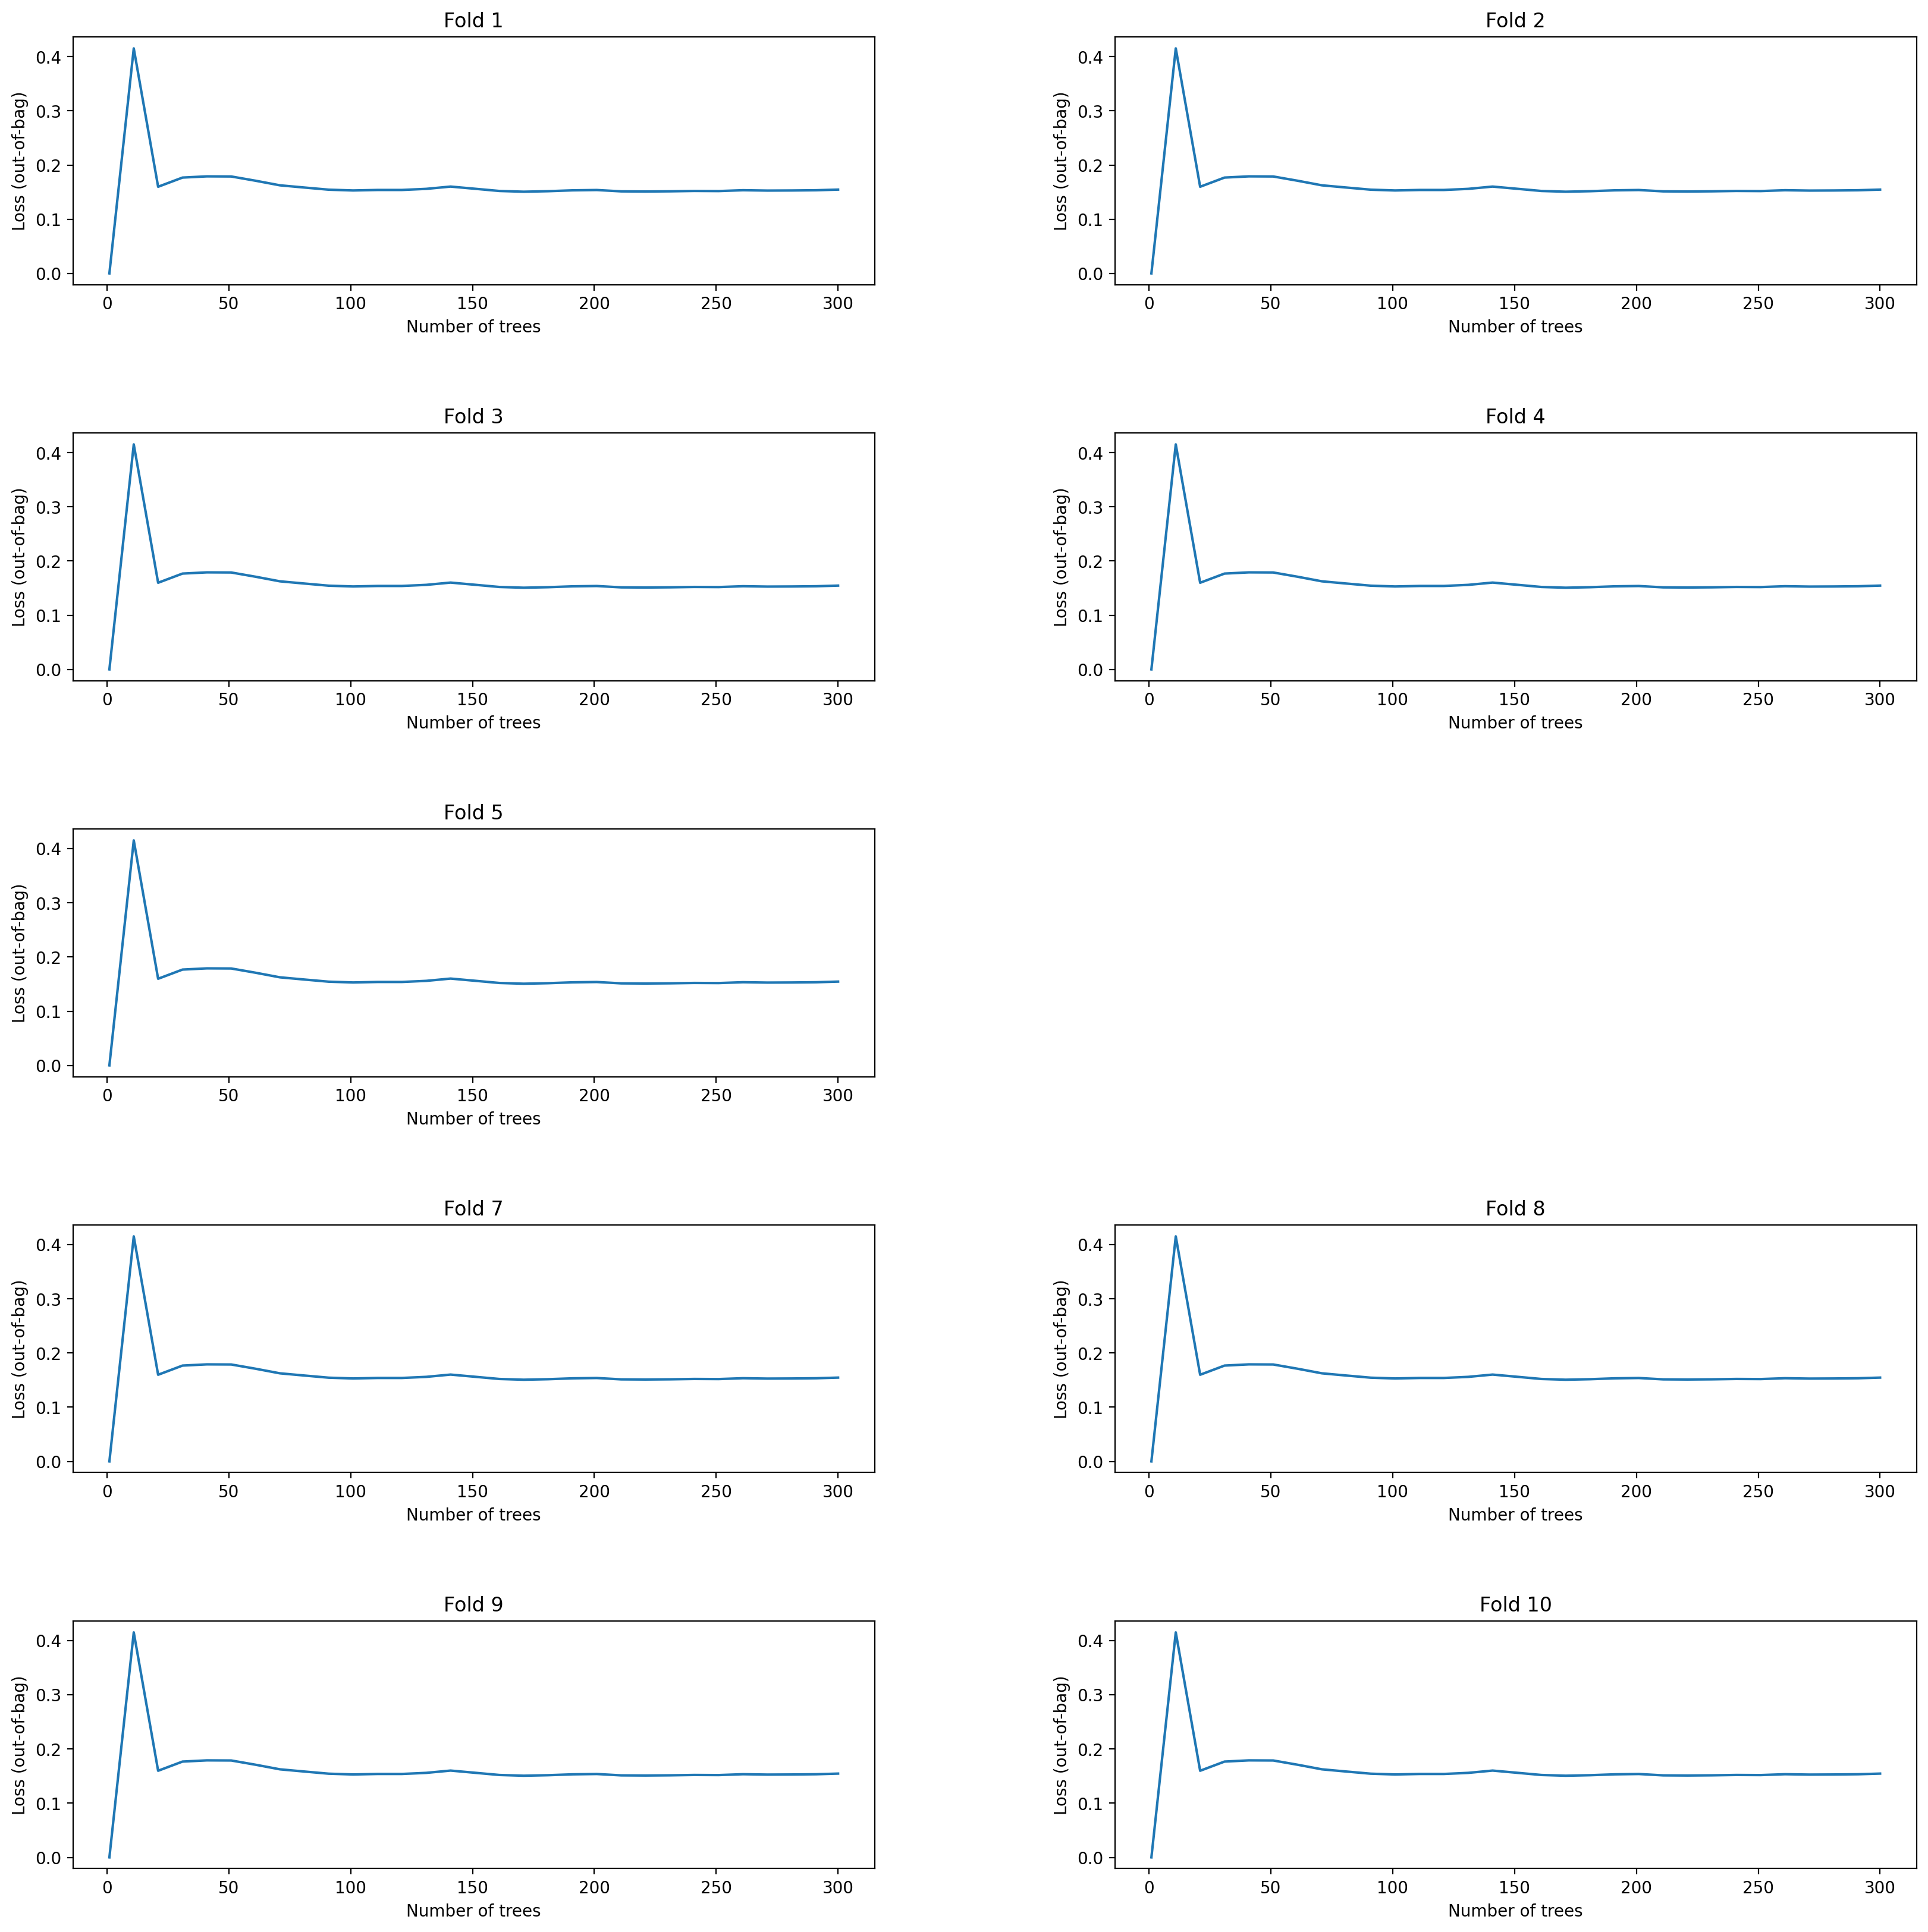

In [267]:
figure, axis = plt.subplots(5, 2, figsize=(20, 20))
plt.subplots_adjust(hspace=0.6, wspace=0.3)

for i, fold_no in enumerate(models.keys()):
    row = i//2
    col = i % 2
    logs = models[fold_no].make_inspector().training_logs()
    axis[row, col].plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
    axis[row, col].set_title(f"Fold {i+1}")
    axis[row, col].set_xlabel('Number of trees')
    axis[row, col].set_ylabel('Loss (out-of-bag)')

axis[2][1].set_visible(False)
plt.show()

### Step 7: Evaluation

In [268]:
average_loss = 0
average_acc = 0

for _model in  models:
    average_loss += cross_entropy[_model]
    average_acc += accuracy[_model]
    print(f"{_model}: acc: {accuracy[_model]:.4f} loss: {cross_entropy[_model]:.4f}")

print(f"\nAverage accuracy: {average_acc/5:.4f}  Average loss: {average_loss/5:.4f}")

fold_10: acc: 0.9796 loss: 0.1088
fold_1: acc: 0.9796 loss: 0.1088
fold_2: acc: 0.9796 loss: 0.1088
fold_3: acc: 0.9796 loss: 0.1088
fold_4: acc: 0.9796 loss: 0.1088
fold_5: acc: 0.9796 loss: 0.1088
fold_6: acc: 0.9796 loss: 0.1088
fold_7: acc: 0.9796 loss: 0.1088
fold_8: acc: 0.9796 loss: 0.1088
fold_9: acc: 0.9796 loss: 0.1088

Average accuracy: 1.9592  Average loss: 0.2176


### Conclusions